#### This notebook is about analysing how models perform using different sets of features and machine learning techniques for regression after obtaining the optimal hyperparameters settings for the machine learning techniques. The target is smoothed. The machine learning techniques used for classical machine learning regression is support vector machine only.

In [45]:
%matplotlib inline
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
from collections import Counter
from sklearn import neighbors, svm, model_selection, metrics, linear_model
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_validate, train_test_split
from sklearn.utils import resample
from sklearn import preprocessing
from tqdm import tqdm
import datetime as dt
import mpld3

mpld3.enable_notebook()
from statistical_metrics import *
from technical_indicators import *

In [46]:
pd.set_option("display.max_columns", 15)
pd.set_option("display.width", 500)

warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [47]:
def SMA_regression_target(df, n):
    df['Target'] = df['Price'].rolling(window=n, min_periods=n).mean()
    df['Target'] = df['Target'].round(5)
    df['Target'] = df['Target'].shift(-n)
    df.dropna(inplace=True)

    return df


df = pd.read_csv('Data/GBP_USD_1418.csv', index_col=0)

# Set how many days look ahead
look_ahead = 7
df = SMA_regression_target(df, look_ahead)

df.dropna(inplace=True)

df.drop(columns=['Change'], inplace=True)

df = moving_average(df, 5)
df = moving_average(df, 8)
df = moving_average(df, 10)
df = moving_average(df, 13)
df = moving_average(df, 15)
df = moving_average(df, 20)
df = moving_average(df, 21)
df = EMA(df, 5)
df = EMA(df, 10)
df = EMA(df, 15)
df = EMA(df, 20)
df = MACD(df, 12, 26, 9)
df = MACD(df, 21, 55, 13)
df = stochastic_oscillator(df, 5)
df = stochastic_oscillator(df, 8)
df = stochastic_oscillator(df, 10)
df = stochastic_oscillator(df, 13)
df = stochastic_oscillator(df, 15)
df = stochastic_oscillator(df, 20)
df = stochastic_oscillator(df, 21)
df = williams_R(df, 5)
df = williams_R(df, 7)
df = williams_R(df, 8)
df = williams_R(df, 10)
df = williams_R(df, 13)
df = williams_R(df, 14)
df = williams_R(df, 15)
df = williams_R(df, 20)
df = williams_R(df, 21)
df = relative_strength_index(df, 5)
df = relative_strength_index(df, 7)
df = relative_strength_index(df, 8)
df = relative_strength_index(df, 10)
df = relative_strength_index(df, 13)
df = relative_strength_index(df, 14)
df = relative_strength_index(df, 15)
df = relative_strength_index(df, 20)
df = relative_strength_index(df, 21)
df = momentum(df, 5)
df = momentum(df, 7)
df = momentum(df, 8)
df = momentum(df, 10)
df = momentum(df, 13)
df = momentum(df, 14)
df = momentum(df, 15)
df = momentum(df, 20)
df = momentum(df, 21)
df = change_rate(df, 1)
df = change_rate(df, 2)
df = change_rate(df, 3)
df = change_rate(df, 4)
df = change_rate(df, 5)
df = average_true_range(df, 7)
df = average_true_range(df, 14)
df = average_true_range(df, 21)
df = average_directional_index_and_DI(df, 5)
df = average_directional_index_and_DI(df, 7)
df = average_directional_index_and_DI(df, 8)
df = average_directional_index_and_DI(df, 10)
df = average_directional_index_and_DI(df, 13)
df = average_directional_index_and_DI(df, 14)
df = average_directional_index_and_DI(df, 15)
df = average_directional_index_and_DI(df, 20)
df = average_directional_index_and_DI(df, 21)
df.dropna(inplace=True)

In [48]:
# Feature sets


# def feature_set1(df):
#     new_df = df[['Low', 'High', 'ema5', 'Open', '5ma', 'ema10', '8ma', '10ma', 'ema15', '13ma', '15ma', 'ema20', 
#                  '20ma', '21ma', 'Target']].copy()
    
#     return new_df

# def feature_set2(df):
#     new_df = df[['Price', 'Low', 'High', '21ma', '-DI 21', '5ma', '8ma', '10ma', 'ema5', 'momentum 10', 'momentum 14', 
#                  'ADX 8', '-DI 15', '13ma', 'change_rate 2', 'Target']].copy()
        
#     return new_df

# def feature_set3(df):
#     new_df = df[['Price', 'ema5', 'ema20', '21ma', 'ema15', 'ema10', '20ma', 'Low', 'High', 'Target']].copy()
        
#     return new_df

def feature_set1(df):
    new_df = df[['Low', 'High', 'ema5', 'Open', '5ma', 'ema10', '8ma', '10ma', 'ema15', '13ma', '15ma', 'ema20', 
                 '20ma', '21ma', 'Target']].copy()
    
    return new_df

def feature_set2(df):
    new_df = df[['Price', 'Low', 'High', 'change_rate 5', 'MACD_12,26,9', 'ema5', 'momentum 20', 'Open', 'momentum 14', 
                 '21ma', 'Target']].copy()
        
    return new_df

def feature_set3(df):
    new_df = df[['Price', 'Low', 'ema5', 'High', 'momentum 21', 'MACD_21,55,13', 'momentum 7', 'ADX 5', 'Open', 
                 'momentum 20', 'MACD_12,26,9', 'change_rate 2', 'ADX 21', 'Target']].copy()
        
    return new_df

#----------------------------
# def feature_set5(df):
#     new_df = df[['Price', 'Low', 'High', '21ma', '-DI 21', '5ma', '8ma', '10ma', 'ema5', 'momentum 10', 'momentum 14', 
#                  'ADX 8', '-DI 15', 'Target']].copy()
        
#     return new_df

# def feature_set6(df):
#     new_df = df[['Open', 'High', 'Low', 'Price', '5ma', '8ma', '10ma', '21ma', 'RSI 14', '-DI 21', 'Target']].copy()
        
#     return new_df

# def feature_set7(df):
#     new_df = df[['Open', 'High', 'Low', 'Price', '5ma', '8ma', '10ma', 'MACD_12,26,9', 'Target']].copy()
        
#     return new_df

# def feature_set8(df):
#     new_df = df[['Open', 'High', 'Low', 'Price', '%R W5', '%K_W5', '%R W10', '%R W7', '%K_W10', '%R W8', 
#                  '%R W13', '%K_W8', '%K_W13', 'Target']].copy()
    
#     return new_df

# def feature_set9(df):
#     new_df = df[['Open', 'High', 'Low', 'Price', '5ma', '8ma', '10ma', '%R W5', '%R W10', '%R W7', '%R W8', 
#                  '%R W13', 'Target']].copy()
    
#     return new_df

# def feature_set10(df):
#     new_df = df[['Open', 'High', 'Low', 'Price', '%K_W5', '%K_W10', '%K_W8', '%K_W13', 'Target']].copy()
    
#     return new_df

def feature_set4(df):
    new_df = df[['Open', 'High', 'Low', 'Price', '5ma', '8ma', '10ma', '13ma', '15ma', '20ma', '21ma', 
                 'Target']].copy()
    
    return new_df

def feature_set5(df):
    new_df = df[['Open', 'High', 'Low', 'Price', 'ema5', 'ema10', 'ema15', 'ema20', 'Target']].copy()
    
    return new_df

def feature_set6(df):
    new_df = df[['%R W5', '%K_W5', '%R W7', '%R W8', '%K_W8', '%R W10', '%K_W10', 'Target']].copy()
        
    return new_df


def feature_set7(df):
    new_df = df[['Open', 'High', 'Low', 'Price', 'MACD_12,26,9', 'Target']].copy()
        
    return new_df


def feature_set8(df):
    new_df = df[['%K_W5', '%D_W5', '%D_W13', '%D_W15', '%R W5', '%R W21', 'momentum 5', 'momentum 13', 
                 'momentum 20', 'momentum 21', 'change_rate 1', 'change_rate 2', 'change_rate 3', 
                 'change_rate 4', 'ATR_scaled 7', '-DI 5', '-DI 7', '+DI 10', '-DI 20', 'ADX 21', 'Target']].copy()
    
    return new_df

switch = {
    'feature_set1': feature_set1,
    'feature_set2': feature_set2,
    'feature_set3': feature_set3,
    'test_set1': feature_set4,
    'test_set2': feature_set5,
    'test_set3': feature_set6,
    'test_set4': feature_set7,
    'test_set5': feature_set8,
}

In [49]:
def feature_selector(df, feature_set):
    
    df = switch[feature_set](df)
    df.dropna(inplace=True)
    return df

In [50]:
def data_processing(df, feature_set):
    df = feature_selector(df, feature_set)
    
    df = df.replace([np.inf, -np.inf], np.nan)
    # Drop na, nan and nat rows
    df.dropna(inplace=True)
    
    tmp_df = df.copy()
    tmp_df.drop(columns=['Target'], inplace=True)
    
    X = tmp_df.values
    y = df['Target'].values

    return X, y, df

In [51]:
def build_model(kernel, C, epsilon, X_train, y_train, X_test, y_test):
    
    clf = svm.SVR(kernel=kernel, C=C, epsilon=epsilon)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    train_prediction = clf.predict(X_train)
    test_prediction = clf.predict(X_test)
    
    train_data = {'Train': y_train, 'Train_Predict': train_prediction}
    df_comparison_train = pd.DataFrame(train_data)
    
    test_data = {'Actual': y_test , 'Predicted': test_prediction}
    df_comparison_test = pd.DataFrame(test_data)
    
    rmse, nrmse = normalised_and_root_mean_square_error(df_comparison_test, 'Actual', 'Predicted')
    mae = mean_absolute_error(df_comparison_test, 'Actual', 'Predicted')
    mape = mean_absolute_percentage_error(df_comparison_test, 'Actual', 'Predicted')
    
    performance_name_list = ['rmse', 'nrmse', 'mae', 'mape']
    performance_list = [rmse, nrmse, mae, mape]
    
    return train_prediction, test_prediction, performance_list, performance_name_list


In [52]:
def feature_comparison(original_df, kernel_list, C, epsilon, split_pct, feature_list):
    
    n = len(feature_list) * len(kernel_list)
    color_iterator = iter(cm.rainbow(np.linspace(0,1,n)))
    
    train_prediction_list = []
    
    test_prediction_list = []
    
    prediction_name_list = []
    performance_storage = []
    color_storage = []
    
    for i in range(len(kernel_list)):
        for n in range(len(feature_list)):
            color = next(color_iterator)

            df = original_df.copy()
            X, y, df = data_processing(df, feature_list[n])

            split_pct = split_pct
            train_size = int(X.shape[0] * split_pct)

            X_train, X_test = X[0:train_size], X[train_size:]
            y_train, y_test = y[0:train_size], y[train_size:]

            train_prediction, test_prediction, performance_list, performance_name_list = \
                    build_model(kernel_list[i], C, epsilon, X_train, y_train, X_test, y_test)

            prediction_name_list.append('k={} C={} e={} feature_set={}'.format(kernel_list[i], C, epsilon, 
                                                                               feature_list[n]))

            train_prediction_list.append(train_prediction)
            test_prediction_list.append(test_prediction)

            performance_storage.append(performance_list)
            color_storage.append(color)
    
    # Train comparison
    plt.figure(figsize=(12,8))
    plt.plot(y_train, color='black', label='actual')
    for i in range(len(train_prediction_list)):
        plt.plot(train_prediction_list[i], color=color_storage[i], label=prediction_name_list[i])
    
    plt.title('Model Performance on Train Set')
    plt.legend(loc='upper right')
    
    # Test comparison
    plt.figure(figsize=(12,8))
    plt.plot(y_test, color='black', label='actual')
    for i in range(len(test_prediction_list)):
        plt.plot(test_prediction_list[i], color=color_storage[i], label=prediction_name_list[i])
        
    plt.title('Model Performance on Test Set')
    plt.legend(loc='upper right')
    
    # Performance analysis
    tmp_list = [[] for _ in range(len(performance_list))]
    
    for i in range(len(performance_list)):
        for j in range(len(performance_storage)):
            tmp_list[i].append(performance_storage[j][i])
    
    name_data = {'Name': prediction_name_list}
    df_param_comparison = pd.DataFrame(name_data)
    for i in range(len(performance_name_list)):
        df_param_comparison[performance_name_list[i]] = tmp_list[i]
        
    print(df_param_comparison)

                                              Name     rmse    nrmse      mae      mape
0      k=rbf C=10 e=0.001 feature_set=feature_set1  0.01056  0.06417  0.00870   0.65401
1      k=rbf C=10 e=0.001 feature_set=feature_set2  0.01000  0.06075  0.00822   0.61824
2      k=rbf C=10 e=0.001 feature_set=feature_set3  0.01037  0.06300  0.00843   0.63494
3         k=rbf C=10 e=0.001 feature_set=test_set1  0.01017  0.06180  0.00834   0.62686
4         k=rbf C=10 e=0.001 feature_set=test_set2  0.01020  0.06198  0.00832   0.62612
5         k=rbf C=10 e=0.001 feature_set=test_set3  0.12966  0.78775  0.11879   9.07673
6         k=rbf C=10 e=0.001 feature_set=test_set4  0.01006  0.06112  0.00816   0.61355
7         k=rbf C=10 e=0.001 feature_set=test_set5  0.18697  1.13596  0.16937  12.92850
8   k=linear C=10 e=0.001 feature_set=feature_set1  0.01052  0.06390  0.00863   0.64925
9   k=linear C=10 e=0.001 feature_set=feature_set2  0.01029  0.06250  0.00842   0.63327
10  k=linear C=10 e=0.001 featur

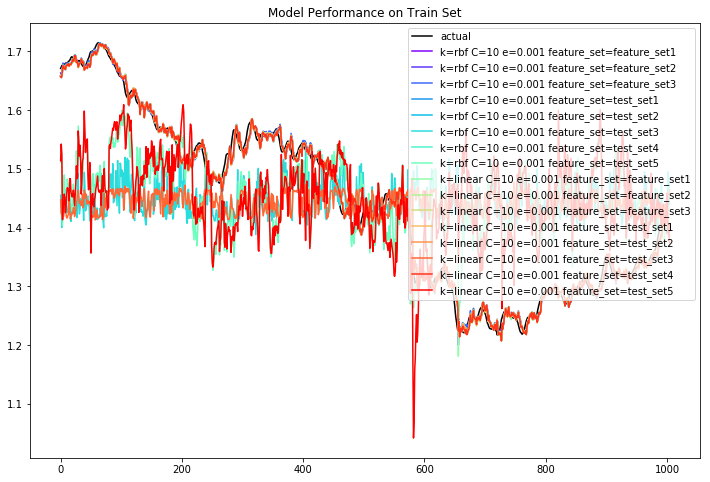

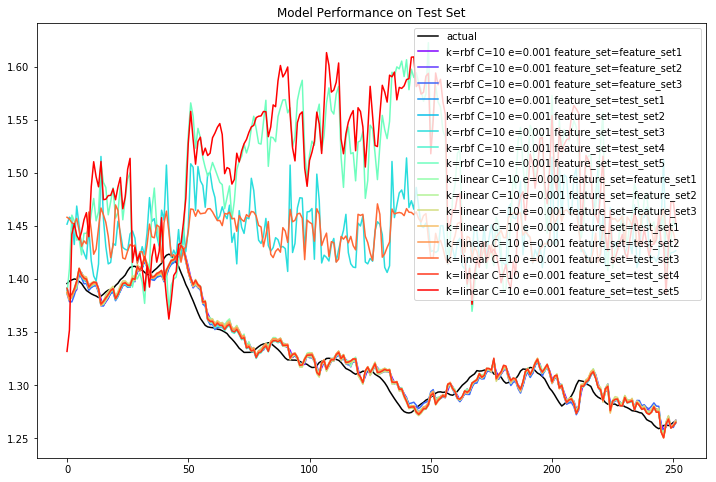

In [53]:
# feature_list = ['feature_set1', 'feature_set2', 'feature_set3', 'feature_set4', 'feature_set6',
#                 'feature_set7', 'feature_set9', 'feature_set10']
feature_list = ['feature_set1', 'feature_set2', 'feature_set3', 'test_set1', 'test_set2', 'test_set3', 
                'test_set4', 'test_set5']
# feature_list = ['feature_set1', 'feature_set2', 'feature_set3']
kernel_list_settings = ['rbf', 'linear']

feature_comparison(df, kernel_list_settings, 10, 0.001, 0.8, feature_list)

In [54]:
# feature_list = ['feature_set5', 'feature_set8']
# feature_comparison(df, ['rbf', 'linear'], 10, 0.001, 0.8, feature_list)

In [55]:
# Analysis

# window=5
#                                                Name     rmse    nrmse      mae     mape
# 0       k=rbf C=10 e=0.001 feature_set=feature_set1  0.00791  0.06944  0.00628  0.53032
# 1       k=rbf C=10 e=0.001 feature_set=feature_set2  0.00776  0.06816  0.00613  0.51695
# 2       k=rbf C=10 e=0.001 feature_set=feature_set3  0.00799  0.07018  0.00638  0.53844
# 3       k=rbf C=10 e=0.001 feature_set=feature_set4  0.00813  0.07135  0.00650  0.54930
# 4       k=rbf C=10 e=0.001 feature_set=feature_set6  0.00820  0.07198  0.00658  0.55501
# 5       k=rbf C=10 e=0.001 feature_set=feature_set7  0.00776  0.06810  0.00614  0.51798
# 6       k=rbf C=10 e=0.001 feature_set=feature_set9  0.06968  0.61173  0.05880  4.88639
# 7      k=rbf C=10 e=0.001 feature_set=feature_set10  0.06974  0.61225  0.05890  4.89534
# 8      k=poly C=10 e=0.001 feature_set=feature_set1  0.01096  0.09625  0.00872  0.73285
# 9      k=poly C=10 e=0.001 feature_set=feature_set2  0.01078  0.09465  0.00862  0.72533
# 10     k=poly C=10 e=0.001 feature_set=feature_set3  0.01081  0.09489  0.00888  0.74952
# 11     k=poly C=10 e=0.001 feature_set=feature_set4  0.01088  0.09554  0.00892  0.75298
# 12     k=poly C=10 e=0.001 feature_set=feature_set6  0.01109  0.09735  0.00884  0.74311
# 13     k=poly C=10 e=0.001 feature_set=feature_set7  0.01070  0.09390  0.00849  0.71303
# 14     k=poly C=10 e=0.001 feature_set=feature_set9  0.06808  0.59767  0.05724  4.75539
# 15    k=poly C=10 e=0.001 feature_set=feature_set10  0.06901  0.60591  0.05822  4.83771
# 16   k=linear C=10 e=0.001 feature_set=feature_set1  0.00788  0.06915  0.00631  0.53274
# 17   k=linear C=10 e=0.001 feature_set=feature_set2  0.00773  0.06787  0.00618  0.52153
# 18   k=linear C=10 e=0.001 feature_set=feature_set3  0.00772  0.06780  0.00620  0.52326
# 19   k=linear C=10 e=0.001 feature_set=feature_set4  0.00786  0.06897  0.00632  0.53383
# 20   k=linear C=10 e=0.001 feature_set=feature_set6  0.00804  0.07055  0.00652  0.55040
# 21   k=linear C=10 e=0.001 feature_set=feature_set7  0.00766  0.06725  0.00613  0.51799
# 22   k=linear C=10 e=0.001 feature_set=feature_set9  0.06790  0.59614  0.05706  4.73988
# 23  k=linear C=10 e=0.001 feature_set=feature_set10  0.06789  0.59608  0.05706  4.73973

# window=10
#                                                Name     rmse    nrmse      mae     mape
# 0       k=rbf C=10 e=0.001 feature_set=feature_set1  0.00991  0.09268  0.00787  0.66300
# 1       k=rbf C=10 e=0.001 feature_set=feature_set2  0.00978  0.09145  0.00774  0.65214
# 2       k=rbf C=10 e=0.001 feature_set=feature_set3  0.01007  0.09416  0.00796  0.67139
# 3       k=rbf C=10 e=0.001 feature_set=feature_set4  0.01027  0.09598  0.00810  0.68352
# 4       k=rbf C=10 e=0.001 feature_set=feature_set6  0.01010  0.09447  0.00798  0.67253
# 5       k=rbf C=10 e=0.001 feature_set=feature_set7  0.00971  0.09074  0.00769  0.64749
# 6       k=rbf C=10 e=0.001 feature_set=feature_set9  0.06963  0.65100  0.05897  4.90100
# 7      k=rbf C=10 e=0.001 feature_set=feature_set10  0.06970  0.65162  0.05912  4.91355
# 8      k=poly C=10 e=0.001 feature_set=feature_set1  0.01269  0.11862  0.01003  0.84125
# 9      k=poly C=10 e=0.001 feature_set=feature_set2  0.01229  0.11489  0.00974  0.81711
# 10     k=poly C=10 e=0.001 feature_set=feature_set3  0.01226  0.11458  0.00987  0.83165
# 11     k=poly C=10 e=0.001 feature_set=feature_set4  0.01234  0.11542  0.00991  0.83490
# 12     k=poly C=10 e=0.001 feature_set=feature_set6  0.01256  0.11745  0.01000  0.83971
# 13     k=poly C=10 e=0.001 feature_set=feature_set7  0.01236  0.11560  0.00975  0.81725
# 14     k=poly C=10 e=0.001 feature_set=feature_set9  0.06824  0.63796  0.05758  4.78341
# 15    k=poly C=10 e=0.001 feature_set=feature_set10  0.06937  0.64857  0.05882  4.88847
# 16   k=linear C=10 e=0.001 feature_set=feature_set1  0.00997  0.09322  0.00788  0.66538
# 17   k=linear C=10 e=0.001 feature_set=feature_set2  0.00965  0.09021  0.00761  0.64241
# 18   k=linear C=10 e=0.001 feature_set=feature_set3  0.00974  0.09105  0.00766  0.64757
# 19   k=linear C=10 e=0.001 feature_set=feature_set4  0.01001  0.09358  0.00791  0.66876
# 20   k=linear C=10 e=0.001 feature_set=feature_set6  0.01010  0.09447  0.00797  0.67334
# 21   k=linear C=10 e=0.001 feature_set=feature_set7  0.00954  0.08921  0.00753  0.63524
# 22   k=linear C=10 e=0.001 feature_set=feature_set9  0.06852  0.64062  0.05793  4.81269
# 23  k=linear C=10 e=0.001 feature_set=feature_set10  0.06845  0.64000  0.05787  4.80789

# window=15
#                                                Name     rmse    nrmse      mae     mape
# 0       k=rbf C=10 e=0.001 feature_set=feature_set1  0.01145  0.11086  0.00900  0.75592
# 1       k=rbf C=10 e=0.001 feature_set=feature_set2  0.01123  0.10870  0.00878  0.73711
# 2       k=rbf C=10 e=0.001 feature_set=feature_set3  0.01213  0.11736  0.00948  0.79879
# 3       k=rbf C=10 e=0.001 feature_set=feature_set4  0.01226  0.11866  0.00956  0.80595
# 4       k=rbf C=10 e=0.001 feature_set=feature_set6  0.01163  0.11253  0.00914  0.76802
# 5       k=rbf C=10 e=0.001 feature_set=feature_set7  0.01125  0.10885  0.00881  0.74059
# 6       k=rbf C=10 e=0.001 feature_set=feature_set9  0.06976  0.67513  0.05930  4.92813
# 7      k=rbf C=10 e=0.001 feature_set=feature_set10  0.06992  0.67670  0.05953  4.94717
# 8      k=poly C=10 e=0.001 feature_set=feature_set1  0.01358  0.13142  0.01058  0.88441
# 9      k=poly C=10 e=0.001 feature_set=feature_set2  0.01329  0.12860  0.01041  0.87181
# 10     k=poly C=10 e=0.001 feature_set=feature_set3  0.01349  0.13057  0.01071  0.90116
# 11     k=poly C=10 e=0.001 feature_set=feature_set4  0.01355  0.13111  0.01074  0.90406
# 12     k=poly C=10 e=0.001 feature_set=feature_set6  0.01357  0.13133  0.01071  0.89780
# 13     k=poly C=10 e=0.001 feature_set=feature_set7  0.01351  0.13072  0.01053  0.88070
# 14     k=poly C=10 e=0.001 feature_set=feature_set9  0.06893  0.66711  0.05859  4.86777
# 15    k=poly C=10 e=0.001 feature_set=feature_set10  0.06966  0.67416  0.05926  4.92466
# 16   k=linear C=10 e=0.001 feature_set=feature_set1  0.01141  0.11040  0.00905  0.76292
# 17   k=linear C=10 e=0.001 feature_set=feature_set2  0.01111  0.10747  0.00872  0.73529
# 18   k=linear C=10 e=0.001 feature_set=feature_set3  0.01147  0.11102  0.00893  0.75427
# 19   k=linear C=10 e=0.001 feature_set=feature_set4  0.01166  0.11283  0.00910  0.76859
# 20   k=linear C=10 e=0.001 feature_set=feature_set6  0.01164  0.11262  0.00908  0.76701
# 21   k=linear C=10 e=0.001 feature_set=feature_set7  0.01101  0.10653  0.00861  0.72629
# 22   k=linear C=10 e=0.001 feature_set=feature_set9  0.06905  0.66829  0.05873  4.88015
# 23  k=linear C=10 e=0.001 feature_set=feature_set10  0.06893  0.66712  0.05856  4.86527